# EDA - Deep Dive

## Summary

**Business Problem**

Academic success of students is important for any university. It was observed that a large of proportion of students either drop out of their course or take a longer time to graduate. The university want to understand why some students are not able to complete their studies as intended and want recommendation on how the situation can be improved.

**Data**

The dataset contains information regarding the demoraphy and socio-economic conditions of students at the time of enrollment. It also have some information regarding the performance of the student before joining and in the first two semesters at the university.

**Insights**

* 32% of the students have dropped out and another 18% students graduated late.
* The following 5 courses have very high dropout and require immediate attention
    * Biofuel production technologies(70%)
    * Informatics engineering(56%)
    * Equinculture(51%)
    * Basic Education(45%)
    * Management(evening attendance)(45%)
* Male students are almost as twice as likely to dropout than female students(Dropout rates are 24% and 45% respectively).
* 40% of the dropouts are 25 years or older at the time of enrollment. While more than 80% of the students graduated are younger than 25.
* There isn't any evidence to suggest that students with educational special needs are doing any worse than the rest of the students.
* Parents' background have an impact on graduation outcomes
    * Students whose parents have finished highschool are slightly more likely to graduate than those haven't. But students whose parents have a bachelors degree or higher are more likely to dropout or graduate late
    * Students who parents are blue collar workers are more likely to graduate than that of white collar workers.
    * Higher dropout rates are observed among students whose parent is not working.
* The dropout rate among indebted students are very high(64%)
* High dropout rates are observed among students who have joined after completing highschool or a bachelors degree. But majority of students joining after secondary school are graduating.
* Most of the students who dropout, do so before completing their first or second semester. Those dropout after have a lower grade compared to others.
    

In [3]:
## Setting up libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [4]:
## importing data

train = pd.read_csv("./../data/1_interim/train.csv")

## What is the current state of graduation outcomes at the university?

### University level outcomes

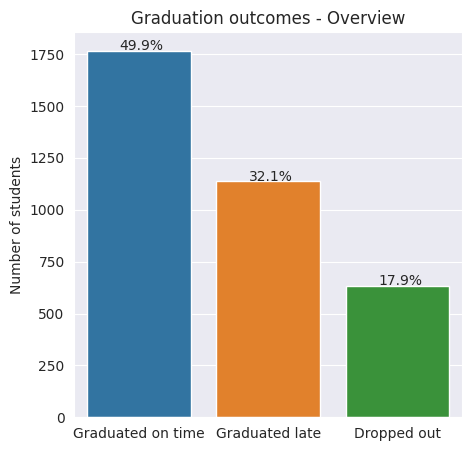

In [5]:
plt.figure(figsize=(5,5))
plot = sns.countplot(data=train, x = "Target")
plt.ylabel("Number of students")
plt.xlabel("")
plt.xticks([0, 1, 2], ['Graduated on time', 'Graduated late', 'Dropped out' ])

# annotations in percentage
total_count = train.shape[0]
for p in plot.patches:
    xy = (p.get_x() + 0.25, p.get_height()+ 3)
    percentage = p.get_height()*100/total_count
    plot.annotate(f"{percentage:.1f}%", xy)

plt.title("Graduation outcomes - Overview")
plt.show()

**32% students dropped out while another 18% graduated late.**

### Course wise outcomes

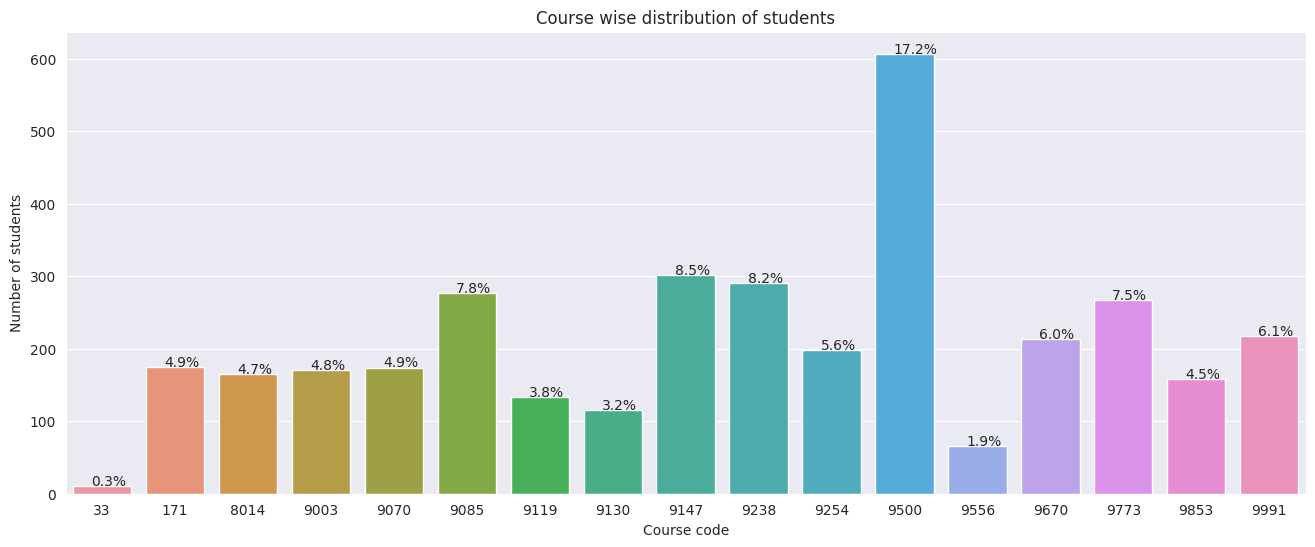

In [6]:
plt.figure(figsize=(16, 6))
fig = sns.countplot(data=train, x = "Course")
plt.xlabel("Course code")
plt.ylabel("Number of students")

for p in fig.patches:
    xy = (p.get_x()+0.25, p.get_height()+1)
    fig.annotate(f"{p.get_height()*100/train.shape[0]:.1f}%", xy)

plt.title("Course wise distribution of students")
plt.show()

<Figure size 1000x800 with 0 Axes>

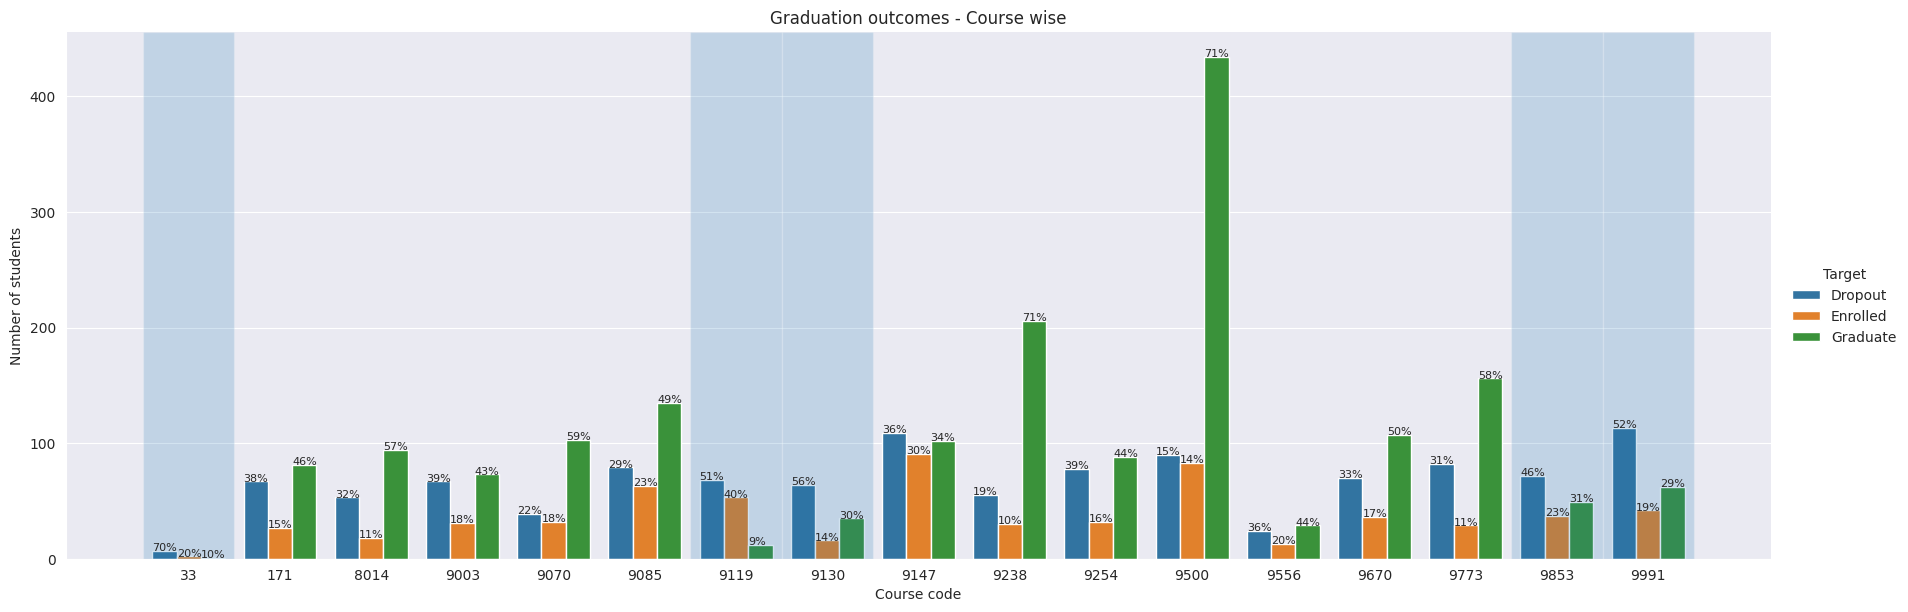

In [7]:
# Prepare the dataset for plotting
course_wise_dropout = train.groupby(["Course", "Target"]).size().reset_index().rename(columns={0:"count"})


#Sorting to get to the same order as groupby so that values can be assigned easily in line2
course_wise_dropout.sort_values(by=["Course", "Target"], inplace=True)
course_wise_dropout["percentage"] = course_wise_dropout.groupby("Course").apply(lambda x: x["count"]/x["count"].sum()).values

#sorting in the plotting order
course_wise_dropout.sort_values(by=["Target", "Course"], inplace=True)

# Plotting
plt.figure(figsize=(10,8))
fig = sns.catplot(data=course_wise_dropout, x="Course", y = "count", kind='bar', hue="Target", height= 6, aspect=3)
plt.xlabel("Course code")
plt.ylabel("Number of students")

# Annotation
for i, bar in enumerate(fig.ax.patches):
    percent = f"{course_wise_dropout.iloc[i, 3]*100:.0f}%"
    xy = (bar.get_x(), bar.get_height())
    fig.ax.annotate(percent, xy, fontsize=8)

#Highlighting
for x in [0, 6, 7, 15, 16]:
    fig.ax.axvspan(x-0.5, x + 0.5, alpha = 0.2) 

plt.title("Graduation outcomes - Course wise")
plt.show()


__The following courses have a much higher dropout rate(45% or above) than the university average__

__33 - 70% - Biofuel production technologies__

__9119 - 51% - Informatics engineering__

__9130 - 56% - Equinculture__

__9853 - 46% - Basic Education__

__9991 - 45% - Management(evening attendance)__

## Are male students more likely to dropout? 

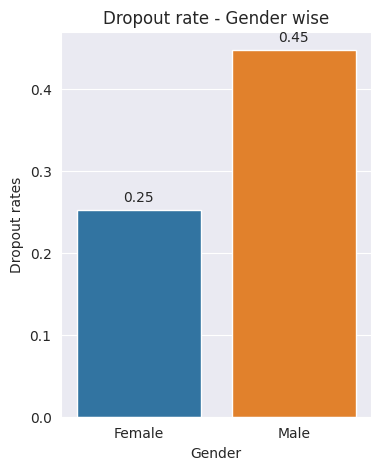

In [8]:
dropout_rates = pd.DataFrame()
dropout_rates["Gender"] = ["Female", "Male"]
dropout_rates["Dropout rates"] = train[train['Target'] == 'Dropout']['Gender'].value_counts()/ train["Gender"].value_counts()

plt.figure(figsize=(4, 5))
fig = sns.barplot(data=dropout_rates, x="Gender", y="Dropout rates")

for i,p in enumerate(fig.patches):
    xy = (p.get_x()+0.3, p.get_height()+0.01)
    fig.annotate(f"{dropout_rates.iloc[i, 1]:.2f}", xy)

plt.title("Dropout rate - Gender wise")
plt.show()

**Drop out rates among male students are significantly different from female students. The rate for male students are almost double as that of female students.**

## Are the older students at a higher risk of dropping out?

<Figure size 400x400 with 0 Axes>

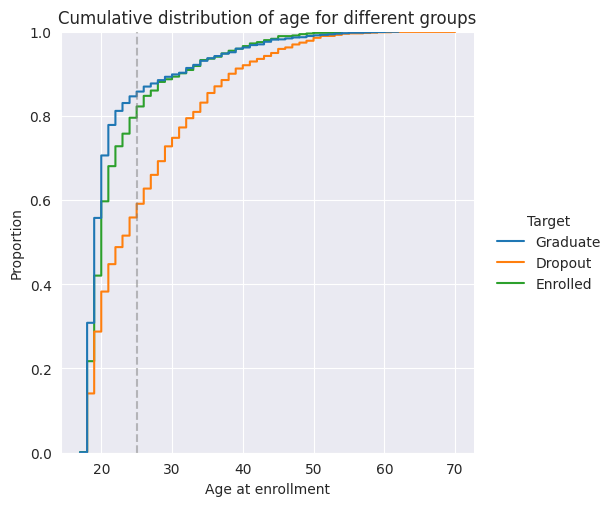

In [9]:
plt.figure(figsize=(4,4))
sns.displot(data=train, x='Age at enrollment', hue='Target', kind='ecdf')
plt.axvline(x=25, linestyle='--', color="grey", alpha=0.5)
plt.title("Cumulative distribution of age for different groups")
plt.show()

**About 40% of the dropouts are 25 years or older at the time of enrollment. While more than 80% of the students graduated are younger than 25.**

## Are students with special needs at a higher risk?

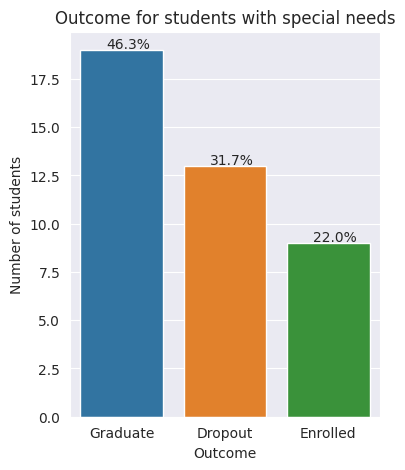

In [10]:
plt.figure(figsize=(4,5))
fig = sns.countplot(data=train[train["Educational special needs"] == 1], x = "Target")
plt.xlabel("Outcome")
plt.ylabel("Number of students")
plt.title("Outcome for students with special needs")

##Annotation
for p in fig.patches:
    total = train[train["Educational special needs"] == 1].shape[0]
    xy = (p.get_x()+0.25, p.get_height()+0.1)
    fig.annotate(f"{p.get_height()*100/total:.1f}%", xy)

The rates of each outcome is very similar to that of global average.

Let's use a $\chi^2$ test to check if the difference is statistically significant. We choose a confidence level of 95%.

Null hypothesis: Graduation outcomes are independent of special needs

Alternate hypthesis: Graduation outcomes dependent on special needs

In [11]:
cross_tab = pd.crosstab(np.where(train["Educational special needs"], "Special needs", "Others"), train["Target"]) ## we are only interested in dropout. so the other categories are aggregated
cross_tab

Target,Dropout,Enrolled,Graduate
row_0,,,
Others,1124,626,1748
Special needs,13,9,19


In [12]:
from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(cross_tab)

## interpret p value
alpha = 0.05 # 95% confidence level
if p < alpha:
    print(f"P value is {p}")
    print("Null hypothesis is rejected.")
else:
    print(f"P value is {p}")
    print("Failed to reject the Null hypothesis.")


P value is 0.786370671823079
Failed to reject the Null hypothesis.


**There isn't enough evidence to suggest that the outcomes among students with special needs are any different from that of the rest.**

## Does the parents' background have an impact on outcomes?

In [13]:
qual_mapping = {1: "highschool",
                38:"pre highschool",
                37:"pre highschool",
                19:"highschool",
                11:"pre highschool",
                3:"graduate",
                2:"graduate",
                34:"unknown",
                4:"masters",
                27:"pre highschool", 
                12:"unknown",
                39:"graduate",
                42:"masters",
                5:"masters",
                40:"graduate",
                6:"unknown",
                36:"less than 4",
                44:"masters", 
                41:"graduate", 
                29:"pre highschool", 
                30:"pre highschool",  
                9:"highschool", 
                10:"highschool", 
                35:"less than 4", 
                14:"highschool", 
                43:"masters", 
                26:"pre highschool", 
                25:"pre highschool", 
                18:"graduate", 
                22:"masters", 
                31:"graduate", 
                20:"highschool"}

train["father_qual"] = train["Father\'s qualification"].map(qual_mapping)
train["mother_qual"] = train["Mother\'s qualification"].map(qual_mapping)

In [14]:
occ_mapping = {0: "student",
                1: "managerial",
                2: "professional",
                3: "technical",
                4: "professional",
                5: "service",
                6: "agriculture",
                7: "craftsmen",
                8: "factory",
                9: "elementary",
                10: "armed forces",
                90: "unknown",
                99: "unknown",
                101: "armed forces",
                102: "armed forces",
                103: "armed forces",
                112: "managerial",
                114: "managerial",
                121: "professional",
                122: "professional",
                123: "professional",
                124: "professional",
                131: "technical",
                132: "technical",
                134: "technical",
                135: "technical",
                141: "clerical",
                143: "technical",
                144: "clerical",
                151: "service",
                152: "service",
                153: "service",
                154: "service",
                161: "agriculture",
                163: "agriculture",
                171: "craftsmen",
                172: "craftsmen",
                174: "craftsmen",
                175: "craftsmen",
                181: "factory",
                182: "factory",
                183: "factory",
                192: "elementary",
                193: "elementary",
                194: "elementary",
                195: "elementary"}

train["father_occ"] = train["Father\'s occupation"].map(occ_mapping)
train["mother_occ"] = train["Mother\'s occupation"].map(occ_mapping)

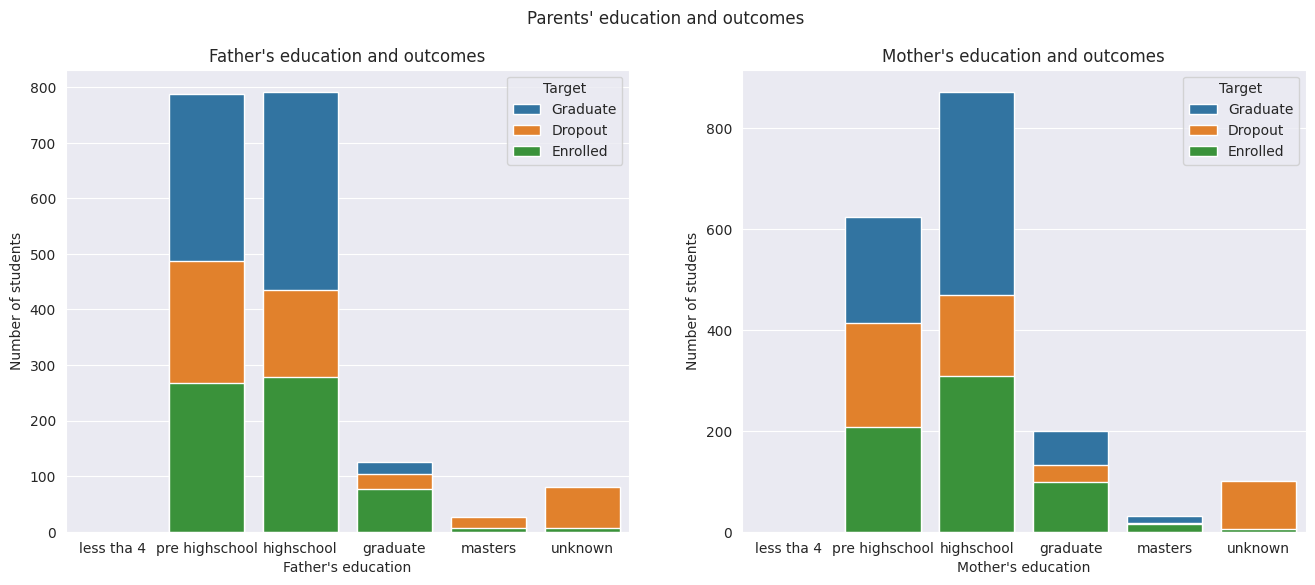

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Parents' education and outcomes")

sns.countplot(data=train, x='father_qual', order=["less tha 4", "pre highschool", "highschool", "graduate", "masters", "unknown"], hue='Target', dodge=False, ax=ax1)
ax1.set_xlabel("Father's education")
ax1.set_ylabel("Number of students")
ax1.set_title("Father's education and outcomes")

sns.countplot(data=train, x='mother_qual', order=["less tha 4", "pre highschool", "highschool", "graduate", "masters", "unknown"], hue='Target', dodge=False, ax=ax2)
ax2.set_xlabel("Mother's education")
ax2.set_ylabel("Number of students")
ax2.set_title("Mother's education and outcomes")
plt.show()

Certain groups show variation in outcomes when compared to global averages. Let's perform $\chi^2$ tests to see if there is some dependece between these factors.

__Father's education and outcomes are related to each other__

In [16]:
father_cross_tab = pd.crosstab(train["father_qual"],  train["Target"])

stat, p, dof, expected = chi2_contingency(father_cross_tab)

## interpret p value
alpha = 0.05 # 95% confidence level
if p < alpha:
    print(f"P value is {p}")
    print("Null hypothesis is rejected.")
else:
    print(f"P value is {p}")
    print("Failed to reject the Null hypothesis.")

P value is 1.1750765934292054e-15
Null hypothesis is rejected.


__Mother's education and outcomes are related to each other__

In [17]:
mother_cross_tab = pd.crosstab(train["mother_qual"], train["Target"])

stat, p, dof, expected = chi2_contingency(mother_cross_tab)

## interpret p value
alpha = 0.05 # 95% confidence level
if p < alpha:
    print(f"P value is {p}")
    print("Null hypothesis is rejected.")
else:
    print(f"P value is {p}")
    print("Failed to reject the Null hypothesis.")

P value is 2.3726993186026422e-20
Null hypothesis is rejected.


__There is a high percentage of dropout among students who haven't declared their parents' education.__

__Students whose parent's have finished highschool are slightly more likely to graduate than those haven't. But students whose parents have a bachelors degree or higher are more likely to dropout or graduate late__

In [18]:
occ_mapping = {0: "student",
                1: "managerial",
                2: "professional",
                3: "technical",
                4: "professional",
                5: "service",
                6: "agriculture",
                7: "craftsmen",
                8: "factory",
                9: "elementary",
                10: "armed forces",
                90: "unknown",
                99: "unknown",
                101: "armed forces",
                102: "armed forces",
                103: "armed forces",
                112: "managerial",
                114: "managerial",
                121: "professional",
                122: "professional",
                123: "professional",
                124: "professional",
                131: "technical",
                132: "technical",
                134: "technical",
                135: "technical",
                141: "clerical",
                143: "technical",
                144: "clerical",
                151: "service",
                152: "service",
                153: "service",
                154: "service",
                161: "agriculture",
                163: "agriculture",
                171: "craftsmen",
                172: "craftsmen",
                174: "craftsmen",
                175: "craftsmen",
                181: "factory",
                182: "factory",
                183: "factory",
                192: "elementary",
                193: "elementary",
                194: "elementary",
                195: "elementary"}

train["father_occ"] = train["Father\'s occupation"].map(occ_mapping)
train["mother_occ"] = train["Mother\'s occupation"].map(occ_mapping)

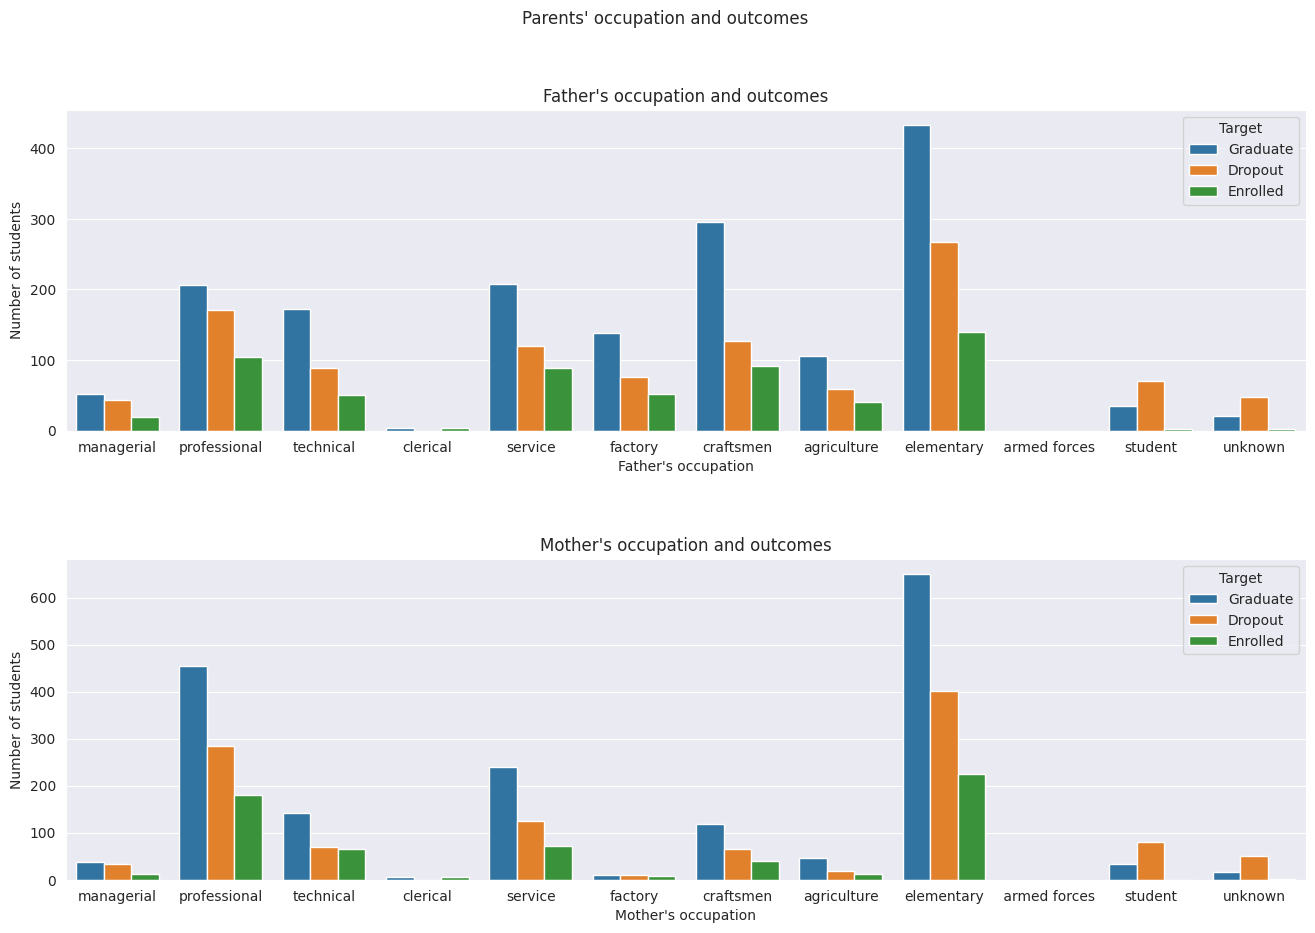

In [19]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 10))
fig.suptitle("Parents' occupation and outcomes")

sns.countplot(data=train, x='father_occ', order=["managerial", "professional", "technical", "clerical", "service", "factory", "craftsmen", "agriculture", "elementary"," armed forces", "student", "unknown"], hue='Target', ax=ax1)
ax1.set_xlabel("Father's occupation")
ax1.set_ylabel("Number of students")
ax1.set_title("Father's occupation and outcomes")


sns.countplot(data=train, x='mother_occ', order=["managerial", "professional", "technical", "clerical", "service", "factory", "craftsmen", "agriculture", "elementary"," armed forces", "student", "unknown"], hue='Target', ax=ax2)
ax2.set_xlabel("Mother's occupation")
ax2.set_ylabel("Number of students")
ax2.set_title("Mother's occupation and outcomes")

plt.subplots_adjust(hspace=0.4)
plt.show()


In [20]:
father_cross_tab = pd.crosstab(train["father_occ"],  train["Target"])

stat, p, dof, expected = chi2_contingency(father_cross_tab)

## interpret p value
alpha = 0.05 # 95% confidence level
if p < alpha:
    print(f"P value is {p}")
    print("Null hypothesis is rejected.")
else:
    print(f"P value is {p}")
    print("Failed to reject the Null hypothesis.")

P value is 2.3186915469766556e-20
Null hypothesis is rejected.


In [21]:
mother_cross_tab = pd.crosstab(train["mother_qual"], train["Target"])

stat, p, dof, expected = chi2_contingency(mother_cross_tab)

## interpret p value
alpha = 0.05 # 95% confidence level
if p < alpha:
    print(f"P value is {p}")
    print("Null hypothesis is rejected.")
else:
    print(f"P value is {p}")
    print("Failed to reject the Null hypothesis.")

P value is 2.3726993186026422e-20
Null hypothesis is rejected.


__Higher dropout rates are observed among students whose parent is not working.__

In [22]:
def acc_type(x):
    white = ["managerial", "professional", "clerical", "technical"]
    blue = ["service", "factory", "craftsmen", "agriculture", "elementary"]

    if x in white:
        return "white"
    elif x in blue:
        return "blue"
    else:
        return "others"

train["father_occ_type"] = train["father_occ"].apply(acc_type)

train["mother_occ_type"] = train["mother_occ"].apply(acc_type)

In [23]:
train["father_occ_type"].value_counts()

blue      2238
white      911
others     390
Name: father_occ_type, dtype: int64

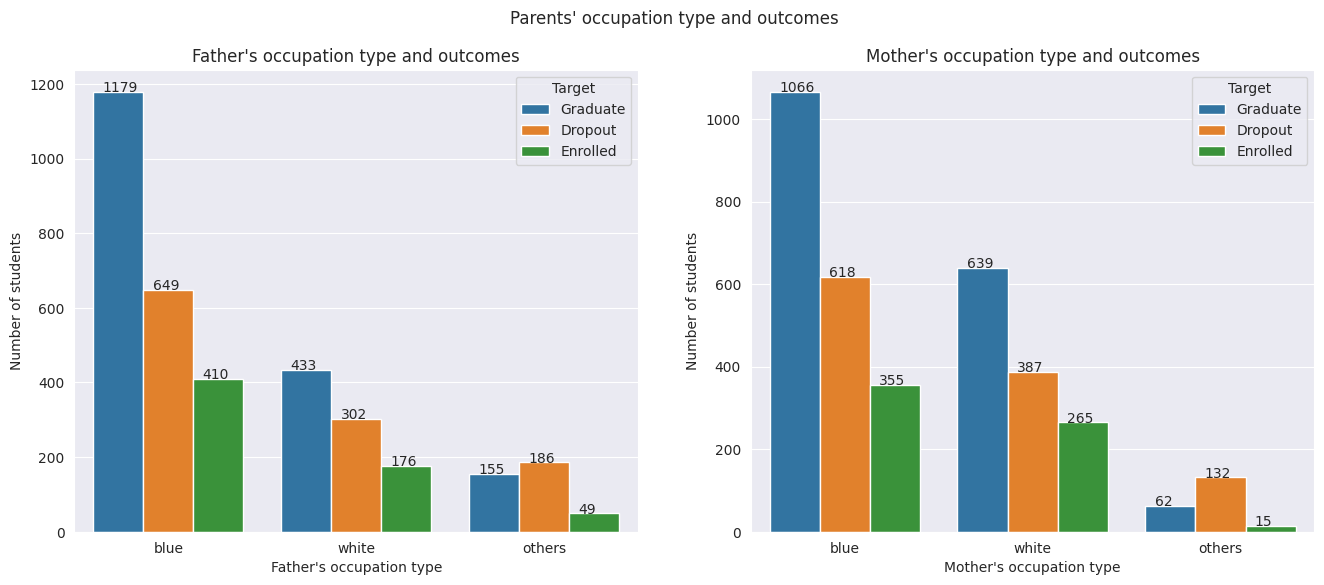

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
fig.suptitle("Parents' occupation type and outcomes")

sns.countplot(data=train, x='father_occ_type', order = ["blue", "white", "others"], hue='Target', ax=ax1)
ax1.set_xlabel("Father's occupation type")
ax1.set_ylabel("Number of students")
ax1.set_title("Father's occupation type and outcomes")

for p in ax1.patches:
    xy = (p.get_x()+0.05, p.get_height())
    ax1.annotate(f"{p.get_height():.0f}", xy)


sns.countplot(data=train, x='mother_occ_type', order = ["blue", "white", "others"], hue='Target', ax=ax2)
ax2.set_xlabel("Mother's occupation type")
ax2.set_ylabel("Number of students")
ax2.set_title("Mother's occupation type and outcomes")


for p in ax2.patches:
    xy = (p.get_x()+0.05, p.get_height())
    ax2.annotate(f"{p.get_height():.0f}", xy)

plt.subplots_adjust(hspace=0.4)
plt.show()


__Graduation rates among blue collar workers' children are slightly better than that of white collar workers__

## Is student debt a reason for dropout?

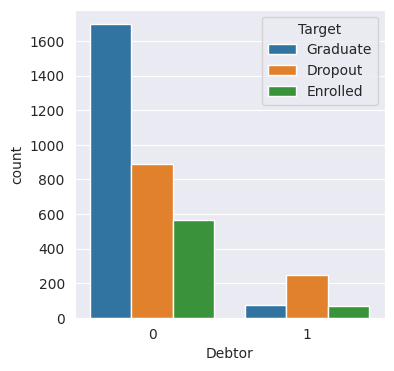

In [25]:
plt.figure(figsize=(4,4))
sns.countplot(data=train, x='Debtor', hue='Target')
plt.show()

In [26]:
total_debtors = train.Debtor.sum()
total_students = train.shape[0]
debtors_dropped = train[train["Debtor"] == 1]["Target"].value_counts()["Dropout"]
print(f"{total_debtors*100/total_students:.2f}% students are debtors. {debtors_dropped*100/total_debtors:.2f}% of them dropped out")

10.99% students are debtors. 64.01% of them dropped out


__The dropout rate among indebted students are very high(64%)__

In [27]:
ct = pd.crosstab(train["Debtor"], train["Tuition fees up to date"])
ct

Tuition fees up to date,0,1
Debtor,,
0,223,2927
1,196,193


__About half of the debtors have pending tuition fee payments__

In [28]:
ct = pd.crosstab(train["Debtor"], train["Scholarship holder"])
ct

Scholarship holder,0,1
Debtor,,
0,2320,830
1,325,64


## Is there a relation between previous qualification and dropout?

In [29]:
#There are too many categories of qualifications. Let's condense them to 6 categories: Pre highschool, highschool, graduate, masters, doctorate and unknown
prev_qual_mapping = {1:'secondary_school',
                    2: 'graduate',
                    3: 'graduate',
                    4: 'masters', 
                    5: 'doctorate',
                    6: 'unknown',
                    9: 'highschool', 
                    10: 'highschool',
                    12: 'unknown', 
                    14: 'highschool', 
                    15: 'pre-highschool', 
                    19: 'highschool', 
                    38: 'pre-highschool', 
                    39: 'graduate', 
                    40: 'graduate', 
                    42: 'masters',
                    43: 'masters'}

train["previous_qual"] = train["Previous qualification"].map(prev_qual_mapping)

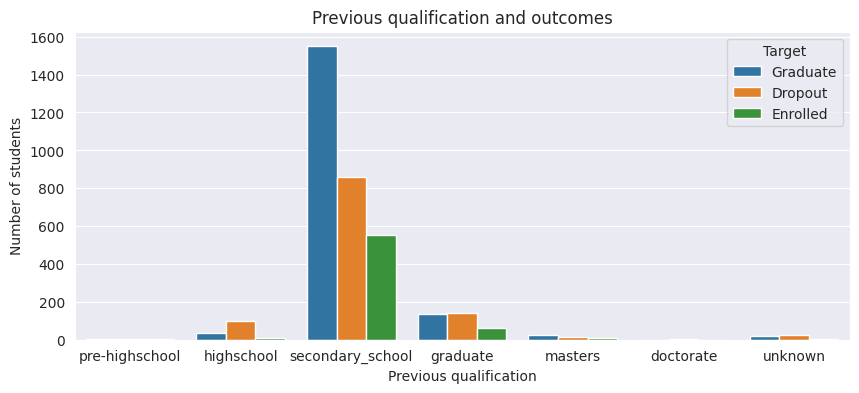

In [30]:
plt.figure(figsize=(10,4))
sns.countplot(data=train, x='previous_qual', order=["pre-highschool", "highschool", "secondary_school", "graduate", "masters","doctorate", "unknown"], hue='Target')
plt.xlabel("Previous qualification")
plt.ylabel("Number of students")
plt.title("Previous qualification and outcomes")
plt.show()

__High dropout rates are observed among students who completed highschool or bachelors, But it is lower among students with secondary schooling.__

Let's investigate if the score in the previous qualification has any indications.

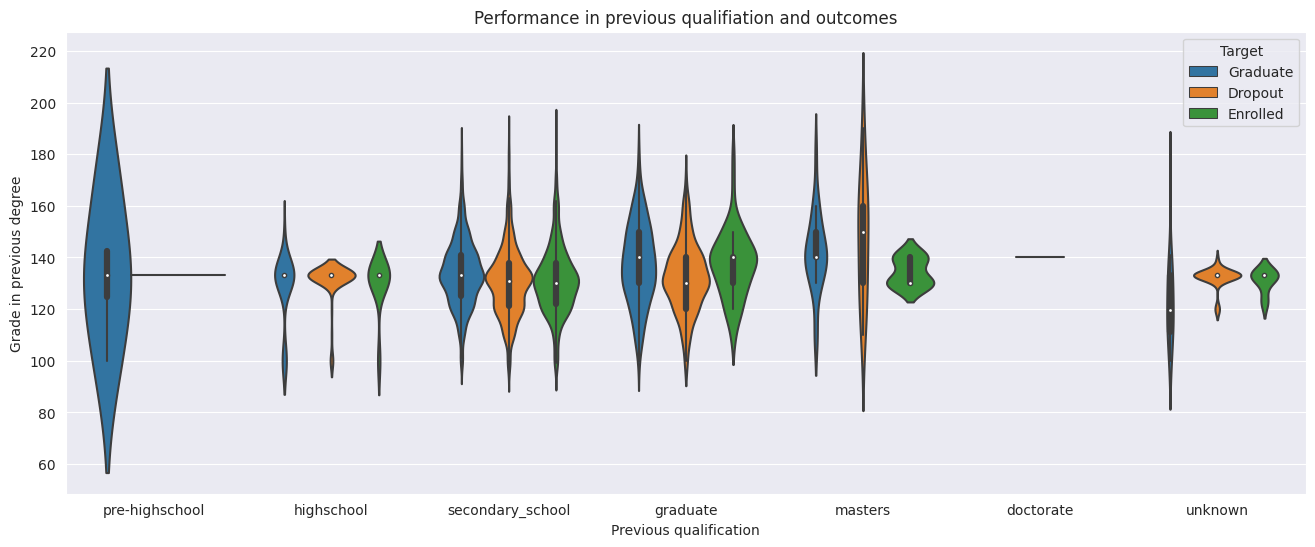

In [31]:
plt.figure(figsize=(16, 6))
sns.violinplot(data=train, x = "previous_qual", y = "Previous qualification (grade)", hue="Target", order=["pre-highschool", "highschool", "secondary_school", "graduate", "masters","doctorate", "unknown"])

plt.xlabel("Previous qualification")
plt.ylabel("Grade in previous degree")
plt.title("Performance in previous qualifiation and outcomes")
plt.show()

There is no obvious pattern between outcomes and previous grades. Let's take a look at admission scores.

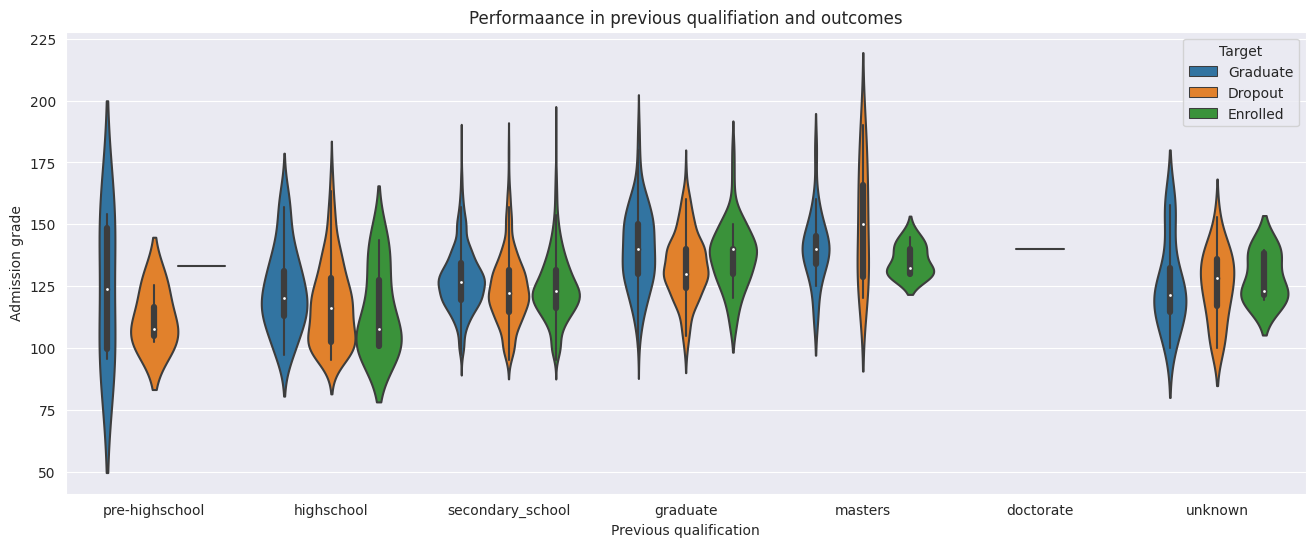

In [32]:
plt.figure(figsize=(16, 6))
sns.violinplot(data=train, x = "previous_qual", y = "Admission grade", hue="Target", order=["pre-highschool", "highschool", "secondary_school", "graduate", "masters","doctorate", "unknown"])

plt.xlabel("Previous qualification")
plt.ylabel("Admission grade")
plt.title("Performaance in previous qualifiation and outcomes")
plt.show("Admission grade and outcomes")

Again, admission scores are not giving any significant insights.

## Does preformance in the first two semesters indicate a propensity for dropping out?

<Figure size 400x400 with 0 Axes>

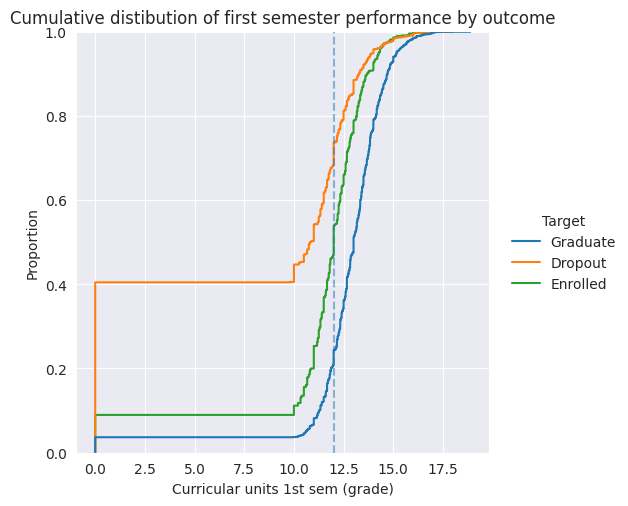

In [33]:
plt.figure(figsize=(4,4))
sns.displot(data=train, x='Curricular units 1st sem (grade)', hue='Target', kind='ecdf')
plt.axvline(x=12, alpha=0.5, linestyle = "--")

plt.title("Cumulative distibution of first semester performance by outcome")
plt.show()

<Figure size 400x400 with 0 Axes>

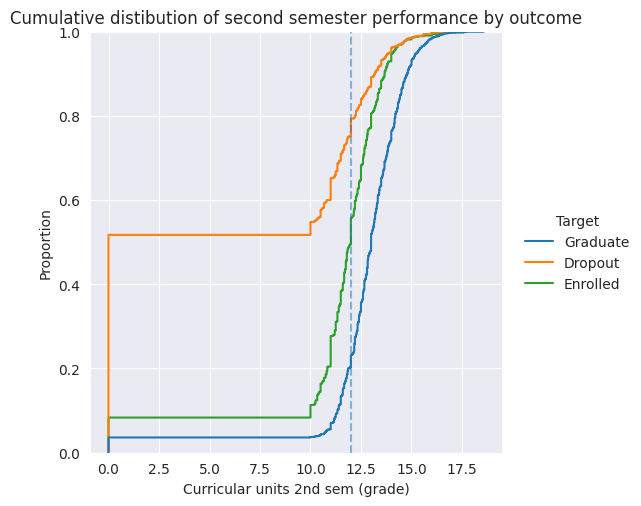

In [34]:
plt.figure(figsize=(4,4))
sns.displot(data=train, x='Curricular units 2nd sem (grade)', hue='Target', kind='ecdf')
plt.axvline(x=12, alpha=0.5, linestyle = "--")
plt.title("Cumulative distibution of second semester performance by outcome")
plt.show()

__Most of the students who dropout have a zero grade, which might mean they have dropped out before the first or second semester completed. Most of the other students have attained scores in the narrow range of 10-15, with students who eventually dropped out scoring lower grades than others__

## How effective are scholarships?

In [35]:
scholarship_holders = train[train["Scholarship holder"] == 1]
print(f"There are {scholarship_holders.shape[0]}({scholarship_holders.shape[0]*100/train.shape[0]:.1f}%) scholarship holders among a total of {train.shape[0]} students.")

There are 894(25.3%) scholarship holders among a total of 3539 students.


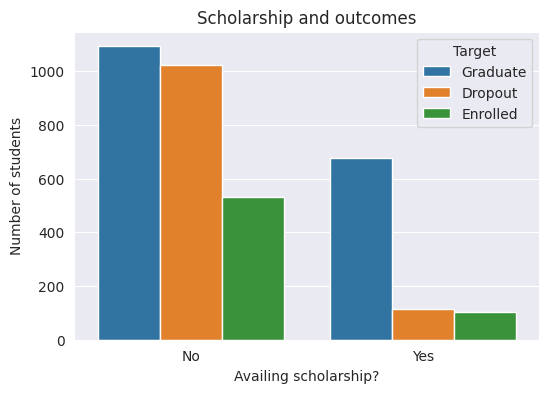

In [36]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='Scholarship holder', hue='Target')

plt.xlabel("Availing scholarship?")
plt.ylabel("Number of students")

plt.xticks([0, 1], ["No", "Yes"])
plt.title("Scholarship and outcomes")
plt.show()

__Outcomes are much more favourable for scholarship holders__

### Who is getting the scholarships?

<Figure size 400x400 with 0 Axes>

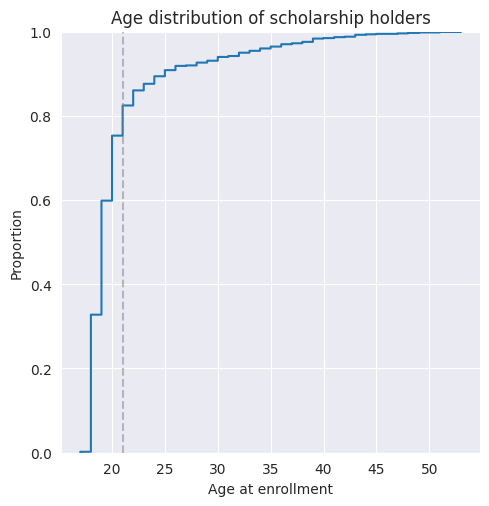

In [37]:
plt.figure(figsize=(4,4))
sns.displot(data=scholarship_holders, x='Age at enrollment', kind='ecdf')
plt.axvline(x=21, linestyle='--', color="grey", alpha=0.5)
plt.title("Age distribution of scholarship holders")
plt.show()

__More than 80% of scholarship holder are 21 or younger__

<AxesSubplot: xlabel='Scholarship holder', ylabel='Admission grade'>

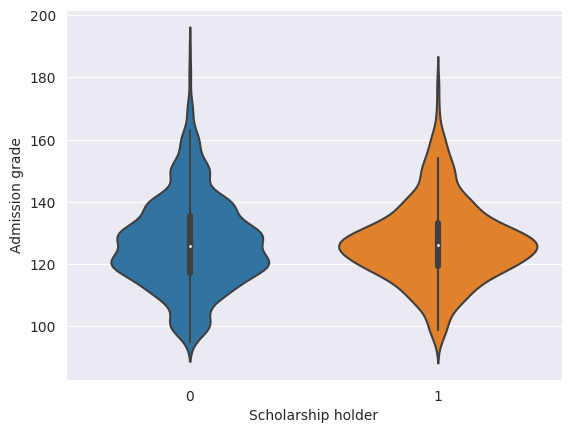

In [38]:
sns.violinplot(data=train, y = "Admission grade", x = "Scholarship holder")

Text(0.5, 1.0, 'Scholarship and previous performance')

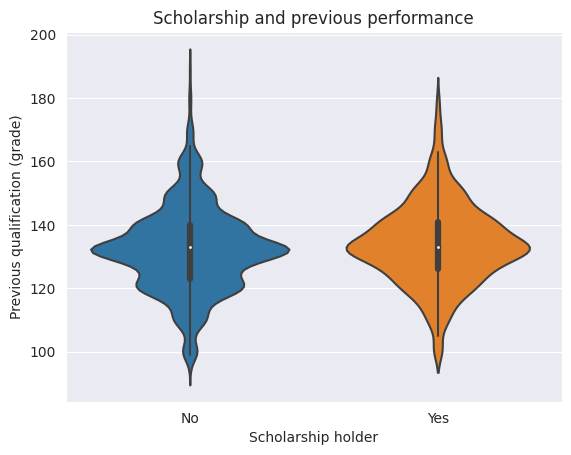

In [39]:
sns.violinplot(data=train, y = "Previous qualification (grade)", x = "Scholarship holder")

plt.xticks([0,1], ["No", "Yes"])
plt.xlabel("Scholarship holder")
plt.title("Scholarship and previous performance")

__More scholarships are obtained by students with a better performance record as expected.__